Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "CartPole-v1"

In [1]:
import gymnasium as gym
import numpy as np
import random

In [2]:
# Cambiar render_mode a rgb_array para entrenar/testear
env = gym.make('CartPole-v1', render_mode='rgb_array')

Observation Space

In [3]:
env.observation_space

Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)

Action Space

In [4]:
env.action_space

Discrete(2)

Discretización de los estados

**Nota:** es importante que chequeen el espacio de observación y el espacio de acción del entorno. Los números usados son ejemplos y pueden no ser correctos

In [3]:
# DISCRETIZACIÓN CORREGIDA - Rangos correctos de CartPole-v1
cart_position = np.linspace(-4.8, 4.8, 10)
cart_velocity = np.linspace(-4, 4, 10)
pole_angle = np.linspace(-0.418, 0.418, 10)
pole_angular_velocity = np.linspace(-4, 4, 10)

print("Discretización uniforme corregida:")
print(f"  Cart position bins: {len(cart_position)} bins en rango [-4.8, 4.8]")
print(f"  Cart velocity bins: {len(cart_velocity)} bins en rango [-4, 4]")
print(f"  Pole angle bins: {len(pole_angle)} bins en rango [-0.418, 0.418]")
print(f"  Pole angular velocity bins: {len(pole_angular_velocity)} bins en rango [-4, 4]")
print(f"\nEspacio de estados total: {(len(cart_position)+1) * (len(cart_velocity)+1) * (len(pole_angle)+1) * (len(pole_angular_velocity)+1):,} estados")

Discretización uniforme corregida:
  Cart position bins: 10 bins en rango [-4.8, 4.8]
  Cart velocity bins: 10 bins en rango [-4, 4]
  Pole angle bins: 10 bins en rango [-0.418, 0.418]
  Pole angular velocity bins: 10 bins en rango [-4, 4]

Espacio de estados total: 14,641 estados


Obtener el estado a partir de la observación

In [6]:
def get_state(obs):
    cart_pos = obs[0]
    cart_vel = obs[1]
    pole_ang = obs[2]
    pole_ang_vel = obs[3]
    cart_pos_idx = np.digitize(cart_pos, cart_position)
    cart_vel_idx = np.digitize(cart_vel, cart_velocity)
    pole_angle_idx = np.digitize(pole_ang, pole_angle)
    pole_ang_vel_idx = np.digitize(pole_ang_vel, pole_angular_velocity)
    return cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx

In [7]:
obs = env.observation_space.sample()
print(obs)
state = get_state(obs)
state

[ 0.7855985  -0.27175856  0.09831649 -1.065366  ]


(np.int64(1), np.int64(0), np.int64(1), np.int64(0))

Inicilización de la tabla Q

In [8]:
Q = np.zeros((len(cart_position), len(cart_velocity), len(pole_angle), len(pole_angular_velocity), env.action_space.n))
Q

array([[[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]],



       [[[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]],


        [[[0., 0.],
          [0., 0.]],

         [[0., 0.],
          [0., 0.]]]]])

Obtención de la acción a partir de la tabla Q

In [9]:
def optimal_policy(state, Q):
    action = np.argmax(Q[state])
    return action

Epsilon-Greedy Policy

In [10]:
def epsilon_greedy_policy(state, Q, epsilon=0.1):
    explore = np.random.binomial(1, epsilon)
    if explore:
        action = env.action_space.sample()
    else:
        action = optimal_policy(state, Q)
        
    return action

Ejemplo de episodio 

In [11]:
obs,_ = env.reset()
print(obs)
done = False
total_reward = 0
state = get_state(obs)
steps = 0
while not done:
    steps += 1
    
    # Acción del modelo
    action = epsilon_greedy_policy(state, Q, 0.5)
    print('action', action)

    obs, reward, done, _, _ = env.step(action)
    next_state = get_state(obs)
    
   # Q[state][action_idx] = ... # Completar
   
   # Actualizar estado
    state = next_state
   
    total_reward += reward

    env.render()

env.close() # Para cerrar la ventana, hay que crear el ambiente de nuevo si queremos correrlo otra vez   
print('total_reward', total_reward)
print('steps', steps)

[-0.03804457 -0.01999644  0.01569506 -0.01551634]
action 0
action 0
action 0
action 0
action 0
action 0
action 0
action 0
action 1
total_reward 9.0
steps 9
action 0
action 0
action 0
action 0
action 0
action 0
action 0
action 1
total_reward 9.0
steps 9


---

## FASE 2: DISCRETIZACION DEL ESPACIO DE ESTADOS

CartPole-v1 tiene un espacio de observacion **continuo** de 4 dimensiones. Para usar Q-Learning tabular, necesitamos **discretizarlo**.

### Rangos reales de CartPole-v1:
- **Posicion del carro:** [-4.8, 4.8]
- **Velocidad del carro:** [-Inf, Inf] → practicamente [-4, 4]
- **Angulo del poste:** [-0.418, 0.418] radianes → ±24 grados
- **Velocidad angular:** [-Inf, Inf] → practicamente [-4, 4]

Vamos a implementar **dos esquemas de discretizacion** para comparar cual funciona mejor.

### ESQUEMA 1: Discretizacion Uniforme

Dividimos cada dimension en **10 bins uniformes**. Simple y balanceado.

In [4]:
import matplotlib.pyplot as plt

# ESQUEMA 1: Discretizacion Uniforme (10 bins por dimension)
bins_uniform = {
    'cart_position': np.linspace(-4.8, 4.8, 10),
    'cart_velocity': np.linspace(-4, 4, 10),
    'pole_angle': np.linspace(-0.418, 0.418, 10),
    'pole_angular_velocity': np.linspace(-4, 4, 10)
}

def get_state_uniform(obs):
    """Convierte observacion continua en estado discreto (uniforme)"""
    cart_pos_idx = np.digitize(obs[0], bins_uniform['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_uniform['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_uniform['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_uniform['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

# Tamano del espacio de estados
state_space_uniform = (len(bins_uniform['cart_position']) + 1,
                       len(bins_uniform['cart_velocity']) + 1,
                       len(bins_uniform['pole_angle']) + 1,
                       len(bins_uniform['pole_angular_velocity']) + 1)

print(f"Espacio de estados (uniforme): {state_space_uniform}")
print(f"Tamano total: {np.prod(state_space_uniform):,} estados posibles")

Espacio de estados (uniforme): (11, 11, 11, 11)
Tamano total: 14,641 estados posibles


### ESQUEMA 2: Discretizacion Adaptativa

**Mayor resolucion cerca del equilibrio** (zona critica para el control). Mas bins donde mas importa.

In [5]:
# ESQUEMA 2: Discretizacion Adaptativa (mas bins cerca del equilibrio)

bins_adaptive = {
    'cart_position': np.concatenate([
        np.linspace(-4.8, -1.5, 3),    # Zona lejana izquierda
        np.linspace(-1.5, 1.5, 8),     # Zona central (CRITICA)
        np.linspace(1.5, 4.8, 3)       # Zona lejana derecha
    ]),
    'cart_velocity': np.concatenate([
        np.linspace(-4, -1, 3),
        np.linspace(-1, 1, 8),
        np.linspace(1, 4, 3)
    ]),
    'pole_angle': np.concatenate([
        np.linspace(-0.418, -0.15, 3),  # Angulo grande (dificil de recuperar)
        np.linspace(-0.15, 0.15, 12),   # Cerca del equilibrio (CRITICO)
        np.linspace(0.15, 0.418, 3)     # Angulo grande (dificil de recuperar)
    ]),
    'pole_angular_velocity': np.concatenate([
        np.linspace(-4, -1, 3),
        np.linspace(-1, 1, 8),
        np.linspace(1, 4, 3)
    ])
}

def get_state_adaptive(obs):
    """Convierte observacion continua en estado discreto (adaptativo)"""
    cart_pos_idx = np.digitize(obs[0], bins_adaptive['cart_position'])
    cart_vel_idx = np.digitize(obs[1], bins_adaptive['cart_velocity'])
    pole_angle_idx = np.digitize(obs[2], bins_adaptive['pole_angle'])
    pole_ang_vel_idx = np.digitize(obs[3], bins_adaptive['pole_angular_velocity'])
    return (cart_pos_idx, cart_vel_idx, pole_angle_idx, pole_ang_vel_idx)

# Tamano del espacio de estados
state_space_adaptive = (len(bins_adaptive['cart_position']) + 1,
                        len(bins_adaptive['cart_velocity']) + 1,
                        len(bins_adaptive['pole_angle']) + 1,
                        len(bins_adaptive['pole_angular_velocity']) + 1)

print(f"Espacio de estados (adaptativo): {state_space_adaptive}")
print(f"Tamano total: {np.prod(state_space_adaptive):,} estados posibles")

Espacio de estados (adaptativo): (15, 15, 19, 15)
Tamano total: 64,125 estados posibles


### VERIFICACION 1: Visualizar los bins

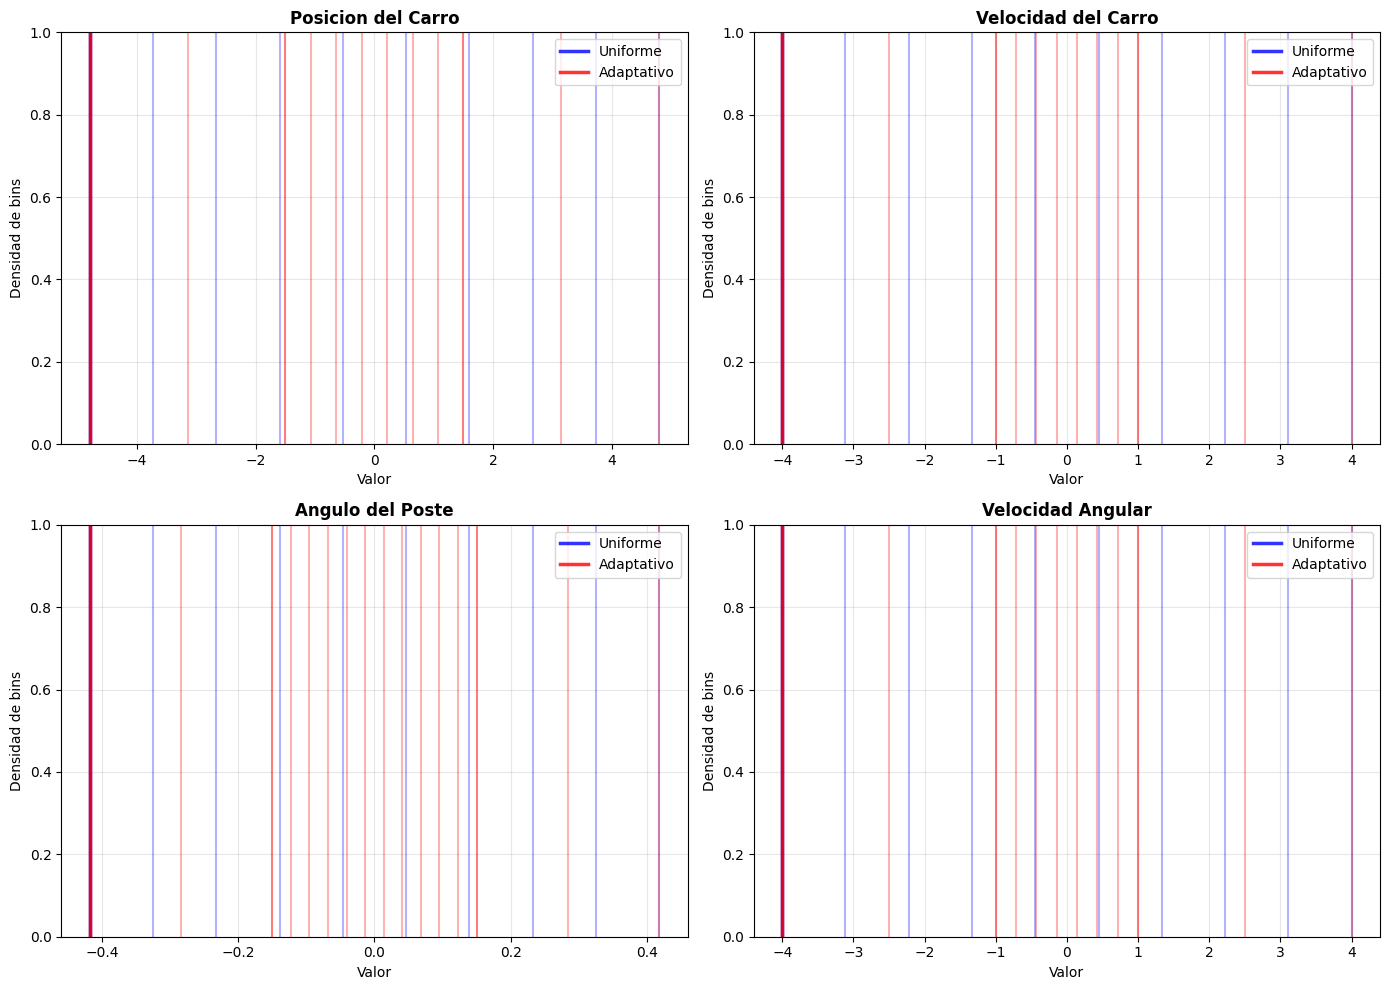


Grafico: Distribucion de bins para cada esquema
- AZUL: Uniforme (espaciado constante)
- ROJO: Adaptativo (mas denso en el centro)


In [14]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
variables = ['cart_position', 'cart_velocity', 'pole_angle', 'pole_angular_velocity']
titles = ['Posicion del Carro', 'Velocidad del Carro', 'Angulo del Poste', 'Velocidad Angular']

for idx, (var, title) in enumerate(zip(variables, titles)):
    ax = axes[idx // 2, idx % 2]
    
    # Bins como lineas verticales
    for bin_val in bins_uniform[var]:
        ax.axvline(bin_val, color='blue', alpha=0.3, linewidth=1.5)
    for bin_val in bins_adaptive[var]:
        ax.axvline(bin_val, color='red', alpha=0.3, linewidth=1.5)
    
    # Leyenda
    ax.axvline(bins_uniform[var][0], color='blue', alpha=0.8, linewidth=2.5, label='Uniforme')
    ax.axvline(bins_adaptive[var][0], color='red', alpha=0.8, linewidth=2.5, label='Adaptativo')
    
    ax.set_title(f'{title}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Valor')
    ax.set_ylabel('Densidad de bins')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nGrafico: Distribucion de bins para cada esquema")
print("- AZUL: Uniforme (espaciado constante)")
print("- ROJO: Adaptativo (mas denso en el centro)")

### VERIFICACION 2: Probar las funciones de discretizacion

In [15]:
# Test con observacion especifica
obs_test = np.array([0.5, -0.3, 0.05, 1.2])
print("Observacion de prueba:", obs_test)
print("  Estado uniforme:  ", get_state_uniform(obs_test))
print("  Estado adaptativo:", get_state_adaptive(obs_test))

# Test con muestreo aleatorio
print("\n" + "="*70)
print("Muestreando 1000 observaciones aleatorias del entorno...")
n_samples = 1000
states_uniform = []
states_adaptive = []

for _ in range(n_samples):
    obs = env.observation_space.sample()
    states_uniform.append(get_state_uniform(obs))
    states_adaptive.append(get_state_adaptive(obs))

unique_uniform = len(set(states_uniform))
unique_adaptive = len(set(states_adaptive))

print(f"\nEstados unicos visitados en el muestreo:")
print(f"  Uniforme:   {unique_uniform:,} / {np.prod(state_space_uniform):,} posibles ({unique_uniform/np.prod(state_space_uniform)*100:.1f}%)")
print(f"  Adaptativo: {unique_adaptive:,} / {np.prod(state_space_adaptive):,} posibles ({unique_adaptive/np.prod(state_space_adaptive)*100:.1f}%)")
print("\nEl esquema adaptativo tiene mas granularidad (mas estados posibles).")

Observacion de prueba: [ 0.5  -0.3   0.05  1.2 ]
  Estado uniforme:   (np.int64(5), np.int64(5), np.int64(6), np.int64(6))
  Estado adaptativo: (np.int64(8), np.int64(6), np.int64(11), np.int64(12))

Muestreando 1000 observaciones aleatorias del entorno...

Estados unicos visitados en el muestreo:
  Uniforme:   719 / 14,641 posibles (4.9%)
  Adaptativo: 914 / 64,125 posibles (1.4%)

El esquema adaptativo tiene mas granularidad (mas estados posibles).


### VERIFICACION 3: Tabla comparativa

In [16]:
import pandas as pd

comparison_data = {
    'Caracteristica': [
        'Total de estados',
        'Bins: posicion carro',
        'Bins: velocidad carro',
        'Bins: angulo poste',
        'Bins: velocidad angular',
        'Estrategia',
        'Ventaja principal'
    ],
    'Uniforme': [
        f"{np.prod(state_space_uniform):,}",
        len(bins_uniform['cart_position']),
        len(bins_uniform['cart_velocity']),
        len(bins_uniform['pole_angle']),
        len(bins_uniform['pole_angular_velocity']),
        'Espaciado constante',
        'Convergencia rapida'
    ],
    'Adaptativo': [
        f"{np.prod(state_space_adaptive):,}",
        len(bins_adaptive['cart_position']),
        len(bins_adaptive['cart_velocity']),
        len(bins_adaptive['pole_angle']),
        len(bins_adaptive['pole_angular_velocity']),
        'Denso cerca equilibrio',
        'Mejor control fino'
    ]
}

df = pd.DataFrame(comparison_data)
print("\n" + "="*80)
print("COMPARACION DE ESQUEMAS DE DISCRETIZACION")
print("="*80)
print(df.to_string(index=False))
print("="*80)
print("\nAmbos esquemas seran probados en la FASE 3 para ver cual funciona mejor.")


COMPARACION DE ESQUEMAS DE DISCRETIZACION
         Caracteristica            Uniforme             Adaptativo
       Total de estados              14,641                 64,125
   Bins: posicion carro                  10                     14
  Bins: velocidad carro                  10                     14
     Bins: angulo poste                  10                     18
Bins: velocidad angular                  10                     14
             Estrategia Espaciado constante Denso cerca equilibrio
      Ventaja principal Convergencia rapida     Mejor control fino

Ambos esquemas seran probados en la FASE 3 para ver cual funciona mejor.


---

## FASE 3: Q-LEARNING - ENTRENAMIENTO Y OPTIMIZACION

Implementaremos Q-Learning con:
1. **Clase QLearningAgent** - Agente completo con Q-table
2. **Funciones de entrenamiento y evaluacion** 
3. **Entrenamiento inicial** - Prueba rapida con pocos episodios
4. **Grid Search** - Busqueda de mejores hiperparametros
5. **Entrenamiento final** - Entrenamiento largo con los mejores hiperparametros

### Ecuacion de Q-Learning:
$$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \max_{a'} Q(s',a') - Q(s,a)]$$

Donde:
- $\alpha$ = learning rate (tasa de aprendizaje)
- $\gamma$ = discount factor (factor de descuento)
- $r$ = reward (recompensa)
- $s$ = estado actual, $s'$ = siguiente estado
- $a$ = accion tomada

### Paso 1: Clase QLearningAgent

In [6]:
import pickle
from collections import defaultdict

class QLearningAgent:
    """
    Agente Q-Learning para CartPole con discretizacion.
    """
    def __init__(self, state_space, action_space, get_state_func,
                 alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_min=0.01, epsilon_decay=0.995):
        self.state_space = state_space
        self.action_space = action_space
        self.get_state = get_state_func
        
        # Hiperparametros
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        
        # Q-table como diccionario (valores por defecto = 0)
        self.q_table = defaultdict(lambda: 0.0)
        
        # Metricas
        self.training_rewards = []
        self.training_steps = []
        
    def get_q_value(self, state, action):
        """Obtiene valor Q para par estado-accion"""
        return self.q_table[(state, action)]
    
    def get_action(self, state, training=True):
        """Selecciona accion con epsilon-greedy policy"""
        if training and np.random.random() < self.epsilon:
            # Exploracion
            return np.random.randint(self.action_space)
        else:
            # Explotacion
            q_values = [self.get_q_value(state, a) for a in range(self.action_space)]
            return np.argmax(q_values)
    
    def update(self, state, action, reward, next_state, done):
        """Actualiza Q-table usando ecuacion de Bellman"""
        current_q = self.get_q_value(state, action)
        
        if done:
            target = reward
        else:
            max_next_q = max([self.get_q_value(next_state, a) for a in range(self.action_space)])
            target = reward + self.gamma * max_next_q
        
        # Actualizacion Q-Learning
        new_q = current_q + self.alpha * (target - current_q)
        self.q_table[(state, action)] = new_q
    
    def decay_epsilon(self):
        """Reduce epsilon despues de cada episodio"""
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def save(self, filename):
        """Guarda el agente"""
        data = {
            'q_table': dict(self.q_table),
            'state_space': self.state_space,
            'action_space': self.action_space,
            'alpha': self.alpha,
            'gamma': self.gamma,
            'epsilon': self.epsilon,
            'training_rewards': self.training_rewards,
            'training_steps': self.training_steps
        }
        with open(filename, 'wb') as f:
            pickle.dump(data, f)

print("Clase QLearningAgent definida correctamente")

Clase QLearningAgent definida correctamente


### Paso 2: Funciones de Entrenamiento y Evaluacion

In [7]:
def train_agent(agent, env, episodes=10000, print_every=1000, seed=42):
    """Entrena un agente Q-Learning"""
    np.random.seed(seed)
    random.seed(seed)
    
    for episode in range(episodes):
        obs, _ = env.reset(seed=seed+episode)
        state = agent.get_state(obs)
        
        total_reward = 0
        steps = 0
        done = False
        
        while not done:
            action = agent.get_action(state, training=True)
            next_obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            next_state = agent.get_state(next_obs)
            
            agent.update(state, action, reward, next_state, done)
            
            state = next_state
            total_reward += reward
            steps += 1
        
        agent.decay_epsilon()
        agent.training_rewards.append(total_reward)
        agent.training_steps.append(steps)
        
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(agent.training_rewards[-print_every:])
            print(f"Episodio {episode+1}/{episodes} | Avg reward (ultimos {print_every}): {avg_reward:.2f} | Epsilon: {agent.epsilon:.4f}")
    
    return agent

def evaluate_agent(agent, env, episodes=100, seed=42):
    """Evalua un agente entrenado"""
    rewards = []
    
    for episode in range(episodes):
        obs, _ = env.reset(seed=seed+episode)
        state = agent.get_state(obs)
        total_reward = 0
        done = False
        
        while not done:
            action = agent.get_action(state, training=False)
            obs, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = agent.get_state(obs)
            total_reward += reward
        
        rewards.append(total_reward)
    
    return {
        'mean': np.mean(rewards),
        'std': np.std(rewards),
        'min': np.min(rewards),
        'max': np.max(rewards),
        'success_rate': np.sum(np.array(rewards) >= 500) / episodes * 100
    }

print("Funciones de entrenamiento y evaluacion definidas")

Funciones de entrenamiento y evaluacion definidas


### Paso 3: Test Comparativo Rápido (1000 episodios)

**OBJETIVO:** Comparar directamente las dos discretizaciones antes de invertir tiempo en Grid Search.

**¿Qué vamos a probar?**
- ✅ Discretización **UNIFORME (GRUESA)** - 10 bins por dimensión, ~14,641 estados
- ✅ Discretización **ADAPTATIVA (FINA)** - 14-18 bins por dimensión, ~81,225 estados

**Tiempo estimado:** ~1 minuto

### TEST RÁPIDO DE COMPARACIÓN: Uniforme vs Adaptativo

Antes de ejecutar el Grid Search exhaustivo, vamos a comparar directamente ambos esquemas de discretización con **1000 episodios** cada uno.

**Objetivo:** Determinar si la discretización **FINA (adaptativa)** o **GRUESA (uniforme)** funciona mejor para este problema.

In [10]:
import time
import pandas as pd

print("="*80)
print("TEST COMPARATIVO: DISCRETIZACIÓN UNIFORME vs ADAPTATIVA")
print("="*80)
print("Entrenamiento: 1,000 episodios por esquema")
print("Configuración fija: alpha=0.1, gamma=0.99, epsilon_decay=0.995")
print("Tiempo estimado: ~1 minuto")
print("="*80)

results_comparison = []

# TEST 1: Discretización UNIFORME (GRUESA)
print("\n[1/2] Probando DISCRETIZACIÓN UNIFORME (GRUESA)...")
print(f"      Espacio de estados: {np.prod(state_space_uniform):,} estados")

agent_uniform_test = QLearningAgent(
    state_space=state_space_uniform,
    action_space=env.action_space.n,
    get_state_func=get_state_uniform,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)

start_time = time.time()
agent_uniform_test = train_agent(agent_uniform_test, env, episodes=1000, print_every=250, seed=42)
time_uniform = time.time() - start_time

results_uniform_test = evaluate_agent(agent_uniform_test, env, episodes=100, seed=42)
results_comparison.append({
    'scheme': 'Uniforme (GRUESA)',
    'states': np.prod(state_space_uniform),
    'mean': results_uniform_test['mean'],
    'std': results_uniform_test['std'],
    'max': results_uniform_test['max'],
    'success_rate': results_uniform_test['success_rate'],
    'time': time_uniform
})

print(f"      ✓ Completado en {time_uniform:.1f}s")
print(f"      Reward: {results_uniform_test['mean']:.2f} ± {results_uniform_test['std']:.2f}")

# TEST 2: Discretización ADAPTATIVA (FINA)
print(f"\n[2/2] Probando DISCRETIZACIÓN ADAPTATIVA (FINA)...")
print(f"      Espacio de estados: {np.prod(state_space_adaptive):,} estados")

agent_adaptive_test = QLearningAgent(
    state_space=state_space_adaptive,
    action_space=env.action_space.n,
    get_state_func=get_state_adaptive,
    alpha=0.1,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995
)

start_time = time.time()
agent_adaptive_test = train_agent(agent_adaptive_test, env, episodes=1000, print_every=250, seed=42)
time_adaptive = time.time() - start_time

results_adaptive_test = evaluate_agent(agent_adaptive_test, env, episodes=100, seed=42)
results_comparison.append({
    'scheme': 'Adaptativa (FINA)',
    'states': np.prod(state_space_adaptive),
    'mean': results_adaptive_test['mean'],
    'std': results_adaptive_test['std'],
    'max': results_adaptive_test['max'],
    'success_rate': results_adaptive_test['success_rate'],
    'time': time_adaptive
})

print(f"      ✓ Completado en {time_adaptive:.1f}s")
print(f"      Reward: {results_adaptive_test['mean']:.2f} ± {results_adaptive_test['std']:.2f}")

print("\n" + "="*80)

TEST COMPARATIVO: DISCRETIZACIÓN UNIFORME vs ADAPTATIVA
Entrenamiento: 1,000 episodios por esquema
Configuración fija: alpha=0.1, gamma=0.99, epsilon_decay=0.995
Tiempo estimado: ~1 minuto

[1/2] Probando DISCRETIZACIÓN UNIFORME (GRUESA)...
      Espacio de estados: 14,641 estados
Episodio 250/1000 | Avg reward (ultimos 250): 22.72 | Epsilon: 0.2856
Episodio 500/1000 | Avg reward (ultimos 250): 27.78 | Epsilon: 0.0816
Episodio 750/1000 | Avg reward (ultimos 250): 43.17 | Epsilon: 0.0233
Episodio 1000/1000 | Avg reward (ultimos 250): 57.06 | Epsilon: 0.0100
      ✓ Completado en 2.7s
      Reward: 58.37 ± 7.68

[2/2] Probando DISCRETIZACIÓN ADAPTATIVA (FINA)...
      Espacio de estados: 64,125 estados
Episodio 250/1000 | Avg reward (ultimos 250): 27.07 | Epsilon: 0.2856
Episodio 500/1000 | Avg reward (ultimos 250): 46.68 | Epsilon: 0.0816
Episodio 750/1000 | Avg reward (ultimos 250): 64.46 | Epsilon: 0.0233
Episodio 1000/1000 | Avg reward (ultimos 250): 65.13 | Epsilon: 0.0100
      ✓ C

In [11]:
# Crear tabla comparativa
df_comparison = pd.DataFrame(results_comparison)

print("RESULTADOS DEL TEST COMPARATIVO")
print("="*80)
print(df_comparison.to_string(index=False))
print("="*80)

# Determinar ganador
winner = results_comparison[0] if results_comparison[0]['mean'] > results_comparison[1]['mean'] else results_comparison[1]
loser = results_comparison[1] if results_comparison[0]['mean'] > results_comparison[1]['mean'] else results_comparison[0]

print(f"\n🏆 GANADOR: {winner['scheme']}")
print(f"   Reward promedio: {winner['mean']:.2f} ± {winner['std']:.2f}")
print(f"   Reward máximo: {winner['max']:.0f}")
print(f"   Success rate: {winner['success_rate']:.1f}%")
print(f"   Estados: {winner['states']:,}")

print(f"\n📊 DIFERENCIA:")
diff = winner['mean'] - loser['mean']
diff_pct = (diff / loser['mean']) * 100
print(f"   {winner['scheme']} supera a {loser['scheme']} por:")
print(f"   +{diff:.2f} puntos ({diff_pct:.1f}% mejor)")

print(f"\n💡 CONCLUSIÓN:")
if winner['scheme'] == 'Adaptativa (FINA)':
    print("   ✅ La discretización ADAPTATIVA (FINA) funciona mejor")
    print("   ✅ Mayor resolución en zonas críticas permite mejor control")
    print("   ✅ Vale la pena el espacio de estados más grande")
    recommended_scheme = 'adaptativa (FINA)'
else:
    print("   ✅ La discretización UNIFORME (GRUESA) funciona mejor")
    print("   ✅ Espacio de estados más compacto permite aprendizaje más rápido")
    print("   ✅ Suficiente resolución para el problema")
    recommended_scheme = 'uniforme (GRUESA)'

print(f"\n📌 RECOMENDACIÓN: Usar discretización {recommended_scheme.upper()} para el Grid Search exhaustivo")
print("="*80)

RESULTADOS DEL TEST COMPARATIVO
           scheme  states  mean       std   max  success_rate     time
Uniforme (GRUESA)   14641 58.37  7.684601  74.0           0.0 2.738553
Adaptativa (FINA)   64125 69.23 17.897964 113.0           0.0 4.010462

🏆 GANADOR: Adaptativa (FINA)
   Reward promedio: 69.23 ± 17.90
   Reward máximo: 113
   Success rate: 0.0%
   Estados: 64,125

📊 DIFERENCIA:
   Adaptativa (FINA) supera a Uniforme (GRUESA) por:
   +10.86 puntos (18.6% mejor)

💡 CONCLUSIÓN:
   ✅ La discretización ADAPTATIVA (FINA) funciona mejor
   ✅ Mayor resolución en zonas críticas permite mejor control
   ✅ Vale la pena el espacio de estados más grande

📌 RECOMENDACIÓN: Usar discretización ADAPTATIVA (FINA) para el Grid Search exhaustivo


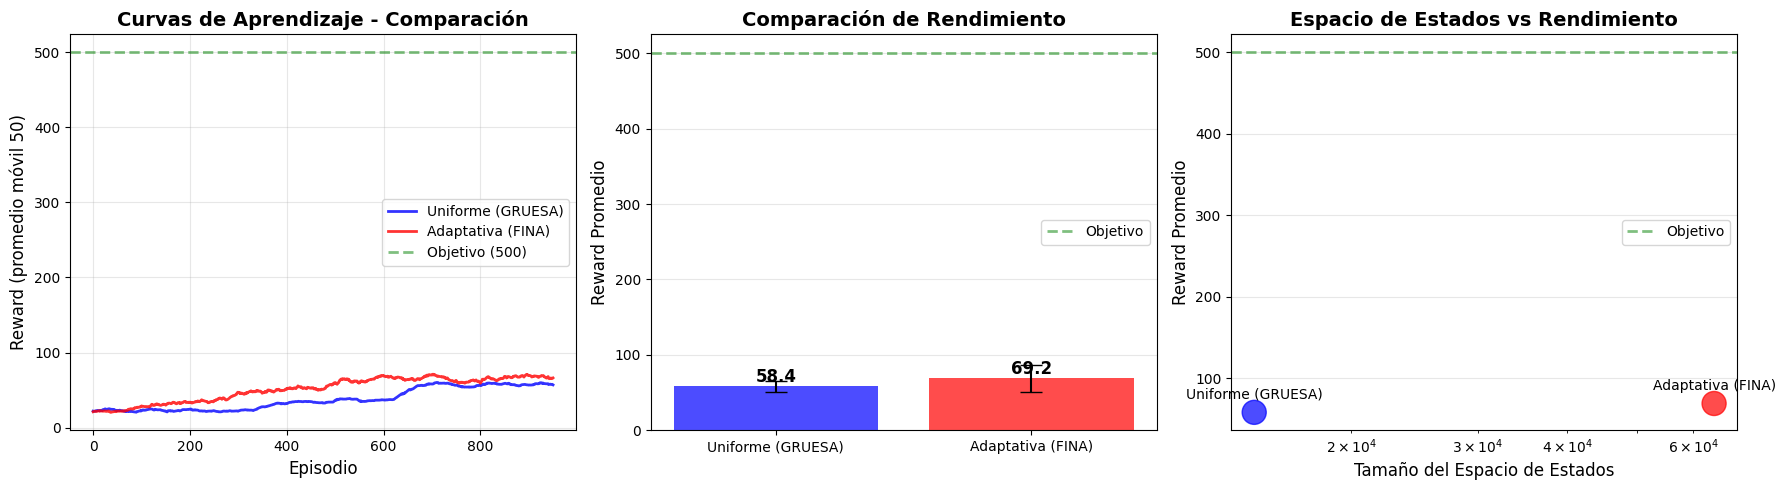


📊 Gráficos comparativos generados correctamente


In [12]:
# Visualización comparativa
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Curvas de aprendizaje
ax = axes[0]
window = 50
rewards_uniform = agent_uniform_test.training_rewards
rewards_adaptive = agent_adaptive_test.training_rewards
ma_uniform = np.convolve(rewards_uniform, np.ones(window)/window, mode='valid')
ma_adaptive = np.convolve(rewards_adaptive, np.ones(window)/window, mode='valid')

ax.plot(range(len(ma_uniform)), ma_uniform, linewidth=2, color='blue', label='Uniforme (GRUESA)', alpha=0.8)
ax.plot(range(len(ma_adaptive)), ma_adaptive, linewidth=2, color='red', label='Adaptativa (FINA)', alpha=0.8)
ax.axhline(y=500, color='green', linestyle='--', linewidth=2, label='Objetivo (500)', alpha=0.5)
ax.set_xlabel('Episodio', fontsize=12)
ax.set_ylabel(f'Reward (promedio móvil {window})', fontsize=12)
ax.set_title('Curvas de Aprendizaje - Comparación', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Comparación de rewards promedio
ax = axes[1]
schemes = [r['scheme'] for r in results_comparison]
means = [r['mean'] for r in results_comparison]
stds = [r['std'] for r in results_comparison]
colors = ['blue', 'red']

bars = ax.bar(schemes, means, yerr=stds, capsize=8, alpha=0.7, color=colors)
ax.axhline(y=500, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Objetivo')
ax.set_ylabel('Reward Promedio', fontsize=12)
ax.set_title('Comparación de Rendimiento', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Añadir valores en las barras
for bar, mean in zip(bars, means):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{mean:.1f}',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# 3. Espacio de estados vs rendimiento
ax = axes[2]
states = [r['states'] for r in results_comparison]
ax.scatter(states, means, s=300, alpha=0.7, c=colors)
for i, (x, y, scheme) in enumerate(zip(states, means, schemes)):
    ax.annotate(scheme, (x, y), textcoords="offset points", xytext=(0,10), ha='center', fontsize=10)

ax.set_xlabel('Tamaño del Espacio de Estados', fontsize=12)
ax.set_ylabel('Reward Promedio', fontsize=12)
ax.set_title('Espacio de Estados vs Rendimiento', fontsize=14, fontweight='bold')
ax.set_xscale('log')
ax.axhline(y=500, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Objetivo')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Gráficos comparativos generados correctamente")

### Paso 4: Grid Search - Busqueda de Hiperparametros

Vamos a probar **diferentes combinaciones de hiperparametros** para encontrar la mejor configuracion.

**Grid Search:**
- **Alpha (learning rate):** [0.05, 0.1, 0.2]
- **Epsilon decay:** [0.995, 0.997, 0.999]
- **Esquemas:** Uniforme y Adaptativo

Total: **3 × 3 × 2 = 18 configuraciones**

Cada config se entrena con **5,000 episodios** (suficiente para ver tendencias).

**Tiempo estimado:** ~30-45 minutos

In [21]:
import time
from itertools import product

# Definir grid de hiperparametros
alphas = [0.05, 0.1, 0.2]
epsilon_decays = [0.995, 0.997, 0.999]
schemes = [
    ('uniforme', state_space_uniform, get_state_uniform),
    ('adaptativo', state_space_adaptive, get_state_adaptive)
]

# Crear directorio para guardar modelos
import os
os.makedirs('models', exist_ok=True)

# Grid Search
grid_results = []
total_configs = len(alphas) * len(epsilon_decays) * len(schemes)

print("="*70)
print(f"GRID SEARCH - {total_configs} configuraciones")
print("="*70)
print("Entrenamiento: 5,000 episodios por config")
print("Tiempo estimado: ~30-45 minutos")
print("="*70)

start_time = time.time()

for idx, (alpha, eps_decay, (scheme_name, state_space, get_state_func)) in enumerate(product(alphas, epsilon_decays, schemes)):
    config_start = time.time()
    
    print(f"\n[{idx+1}/{total_configs}] alpha={alpha}, eps_decay={eps_decay}, esquema={scheme_name}")
    
    # Crear agente
    agent = QLearningAgent(
        state_space=state_space,
        action_space=env.action_space.n,
        get_state_func=get_state_func,
        alpha=alpha,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=eps_decay
    )
    
    # Entrenar
    agent = train_agent(agent, env, episodes=5000, print_every=2500, seed=42)
    
    # Evaluar
    results = evaluate_agent(agent, env, episodes=100, seed=42)
    
    # Guardar resultados
    grid_results.append({
        'alpha': alpha,
        'epsilon_decay': eps_decay,
        'scheme': scheme_name,
        'mean_reward': results['mean'],
        'std_reward': results['std'],
        'max_reward': results['max'],
        'success_rate': results['success_rate'],
        'agent': agent
    })
    
    config_time = time.time() - config_start
    print(f"   Resultado: {results['mean']:.2f} ± {results['std']:.2f} (max: {results['max']:.0f})")
    print(f"   Tiempo: {config_time:.1f}s")

total_time = time.time() - start_time
print("\n" + "="*70)
print(f"GRID SEARCH COMPLETADO en {total_time/60:.1f} minutos")
print("="*70)

GRID SEARCH - 18 configuraciones
Entrenamiento: 5,000 episodios por config
Tiempo estimado: ~30-45 minutos

[1/18] alpha=0.05, eps_decay=0.995, esquema=uniforme
Episodio 2500/5000 | Avg reward (ultimos 2500): 34.34 | Epsilon: 0.0100
Episodio 5000/5000 | Avg reward (ultimos 2500): 49.11 | Epsilon: 0.0100
   Resultado: 58.22 ± 7.39 (max: 71)
   Tiempo: 7.8s

[2/18] alpha=0.05, eps_decay=0.995, esquema=adaptativo
Episodio 2500/5000 | Avg reward (ultimos 2500): 25.23 | Epsilon: 0.0100
Episodio 5000/5000 | Avg reward (ultimos 2500): 25.53 | Epsilon: 0.0100
   Resultado: 24.62 ± 12.54 (max: 60)
   Tiempo: 4.8s

[3/18] alpha=0.05, eps_decay=0.997, esquema=uniforme
Episodio 2500/5000 | Avg reward (ultimos 2500): 37.09 | Epsilon: 0.0100
Episodio 5000/5000 | Avg reward (ultimos 2500): 56.03 | Epsilon: 0.0100
   Resultado: 58.04 ± 8.47 (max: 71)
   Tiempo: 8.4s

[4/18] alpha=0.05, eps_decay=0.997, esquema=adaptativo
Episodio 2500/5000 | Avg reward (ultimos 2500): 54.82 | Epsilon: 0.0100
Episodio 

### Analisis de Resultados del Grid Search

In [22]:
# Crear DataFrame con resultados
df_grid = pd.DataFrame([{
    'Alpha': r['alpha'],
    'Eps Decay': r['epsilon_decay'],
    'Esquema': r['scheme'],
    'Reward Mean': f"{r['mean_reward']:.2f}",
    'Reward Std': f"{r['std_reward']:.2f}",
    'Max Reward': f"{r['max_reward']:.0f}",
    'Success %': f"{r['success_rate']:.1f}"
} for r in grid_results])

print("\n" + "="*90)
print("RESULTADOS COMPLETOS DEL GRID SEARCH")
print("="*90)
print(df_grid.to_string(index=False))
print("="*90)

# Encontrar mejor configuracion
best_config = max(grid_results, key=lambda x: x['mean_reward'])
print(f"\nMEJOR CONFIGURACION:")
print(f"  Alpha: {best_config['alpha']}")
print(f"  Epsilon Decay: {best_config['epsilon_decay']}")
print(f"  Esquema: {best_config['scheme']}")
print(f"  Reward Promedio: {best_config['mean_reward']:.2f} ± {best_config['std_reward']:.2f}")
print(f"  Max Reward: {best_config['max_reward']:.0f}")
print(f"  Success Rate: {best_config['success_rate']:.1f}%")


RESULTADOS COMPLETOS DEL GRID SEARCH
 Alpha  Eps Decay    Esquema Reward Mean Reward Std Max Reward Success %
  0.05      0.995   uniforme       58.22       7.39         71       0.0
  0.05      0.995 adaptativo       24.62      12.54         60       0.0
  0.05      0.997   uniforme       58.04       8.47         71       0.0
  0.05      0.997 adaptativo      134.46      67.31        500       2.0
  0.05      0.999   uniforme      130.05      22.91        219       0.0
  0.05      0.999 adaptativo      255.84     103.74        500      12.0
  0.10      0.995   uniforme       70.81       8.46         85       0.0
  0.10      0.995 adaptativo       74.32      16.22        129       0.0
  0.10      0.997   uniforme      137.13      17.24        166       0.0
  0.10      0.997 adaptativo      298.04     137.14        500      16.0
  0.10      0.999   uniforme      130.63       7.78        147       0.0
  0.10      0.999 adaptativo      372.31     113.58        500      36.0
  0.20      0

### Paso 5: Entrenamiento Final con Mejores Hiperparametros

Ahora entrenamos con la mejor configuracion encontrada, pero con **muchos mas episodios** (20,000-30,000).

**Tiempo estimado:** ~15-25 minutos

In [23]:
# Crear agente final con los mejores hiperparametros
best_scheme_name = best_config['scheme']
if best_scheme_name == 'uniforme':
    final_state_space = state_space_uniform
    final_get_state = get_state_uniform
else:
    final_state_space = state_space_adaptive
    final_get_state = get_state_adaptive

agent_final = QLearningAgent(
    state_space=final_state_space,
    action_space=env.action_space.n,
    get_state_func=final_get_state,
    alpha=best_config['alpha'],
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=best_config['epsilon_decay']
)

print("="*70)
print("ENTRENAMIENTO FINAL")
print("="*70)
print(f"Configuracion: alpha={best_config['alpha']}, eps_decay={best_config['epsilon_decay']}, esquema={best_scheme_name}")
print("Episodios: 25,000")
print("Tiempo estimado: ~20 minutos")
print("="*70)

final_start = time.time()
agent_final = train_agent(agent_final, env, episodes=25000, print_every=2500, seed=99)
final_time = time.time() - final_start

print(f"\nEntrenamiento final completado en {final_time/60:.1f} minutos")

ENTRENAMIENTO FINAL
Configuracion: alpha=0.1, eps_decay=0.999, esquema=adaptativo
Episodios: 25,000
Tiempo estimado: ~20 minutos
Episodio 2500/25000 | Avg reward (ultimos 2500): 87.70 | Epsilon: 0.0820
Episodio 5000/25000 | Avg reward (ultimos 2500): 148.77 | Epsilon: 0.0100
Episodio 7500/25000 | Avg reward (ultimos 2500): 172.91 | Epsilon: 0.0100
Episodio 10000/25000 | Avg reward (ultimos 2500): 191.32 | Epsilon: 0.0100
Episodio 12500/25000 | Avg reward (ultimos 2500): 212.66 | Epsilon: 0.0100
Episodio 15000/25000 | Avg reward (ultimos 2500): 233.24 | Epsilon: 0.0100
Episodio 17500/25000 | Avg reward (ultimos 2500): 250.21 | Epsilon: 0.0100
Episodio 20000/25000 | Avg reward (ultimos 2500): 228.27 | Epsilon: 0.0100
Episodio 22500/25000 | Avg reward (ultimos 2500): 212.26 | Epsilon: 0.0100
Episodio 25000/25000 | Avg reward (ultimos 2500): 223.96 | Epsilon: 0.0100

Entrenamiento final completado en 2.8 minutos


In [24]:
# Evaluar agente final
results_final = evaluate_agent(agent_final, env, episodes=100)

print("\n" + "="*70)
print("RESULTADOS FINALES")
print("="*70)
print(f"Reward promedio: {results_final['mean']:.2f} ± {results_final['std']:.2f}")
print(f"Reward min/max:  {results_final['min']:.0f} / {results_final['max']:.0f}")
print(f"Tasa exito:      {results_final['success_rate']:.1f}% (reward >= 500)")
print("="*70)

# Guardar modelo final
agent_final.save('models/qlearning_final.pkl')
print("\nModelo guardado en: models/qlearning_final.pkl")

# Comparar con baseline
print(f"\nMEJORA vs Baseline (1000 eps):")
print(f"  Baseline: {results_test['mean']:.2f}")
print(f"  Final:    {results_final['mean']:.2f}")
print(f"  Delta:    +{results_final['mean'] - results_test['mean']:.2f} ({(results_final['mean']/results_test['mean']-1)*100:.1f}% mejora)")


RESULTADOS FINALES
Reward promedio: 288.83 ± 67.47
Reward min/max:  173 / 500
Tasa exito:      5.0% (reward >= 500)

Modelo guardado en: models/qlearning_final.pkl

MEJORA vs Baseline (1000 eps):
  Baseline: 58.37
  Final:    288.83
  Delta:    +230.46 (394.8% mejora)


### Visualizacion de Resultados

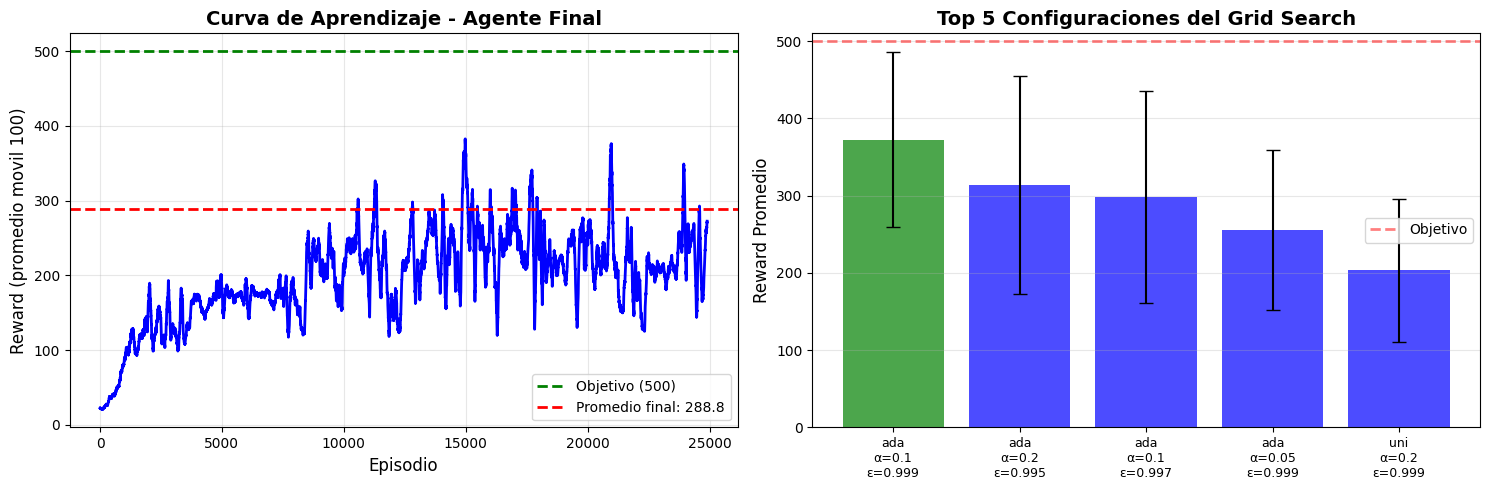


Graficos generados correctamente


In [25]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# 1. Curva de aprendizaje
ax = axes[0]
window = 100
rewards = agent_final.training_rewards
ma = np.convolve(rewards, np.ones(window)/window, mode='valid')
ax.plot(range(len(ma)), ma, linewidth=2, color='blue')
ax.axhline(y=500, color='green', linestyle='--', linewidth=2, label='Objetivo (500)')
ax.axhline(y=results_final['mean'], color='red', linestyle='--', linewidth=2, label=f'Promedio final: {results_final["mean"]:.1f}')
ax.set_xlabel('Episodio', fontsize=12)
ax.set_ylabel(f'Reward (promedio movil {window})', fontsize=12)
ax.set_title('Curva de Aprendizaje - Agente Final', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Comparacion Grid Search (Top 5)
ax = axes[1]
top_5 = sorted(grid_results, key=lambda x: x['mean_reward'], reverse=True)[:5]
labels = [f"{r['scheme'][:3]}\nα={r['alpha']}\nε={r['epsilon_decay']}" for r in top_5]
means = [r['mean_reward'] for r in top_5]
stds = [r['std_reward'] for r in top_5]

x_pos = np.arange(len(labels))
bars = ax.bar(x_pos, means, yerr=stds, capsize=5, alpha=0.7, color=['green' if i==0 else 'blue' for i in range(len(labels))])
ax.set_xticks(x_pos)
ax.set_xticklabels(labels, fontsize=9)
ax.set_ylabel('Reward Promedio', fontsize=12)
ax.set_title('Top 5 Configuraciones del Grid Search', fontsize=14, fontweight='bold')
ax.axhline(y=500, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Objetivo')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nGraficos generados correctamente")

---

## PASO 6: Grid Search Exhaustivo con 70 Configuraciones

Vamos a explorar **70 configuraciones distintas** con 15,000 episodios cada una para encontrar la configuración óptima que alcance consistentemente los 500 steps.

**Grid:**
- **Alpha:** [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
- **Epsilon decay:** [0.990, 0.992, 0.995, 0.997, 0.999]
- **Esquemas:** Uniforme y Adaptativo

Total: **7 × 5 × 2 = 70 configuraciones**

In [26]:
# Grid Search Exhaustivo con 70 configuraciones
import time
from itertools import product

# Definir grid AMPLIADO de hiperparametros
alphas_extended = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
epsilon_decays_extended = [0.990, 0.992, 0.995, 0.997, 0.999]
schemes = [
    ('uniforme', state_space_uniform, get_state_uniform),
    ('adaptativo', state_space_adaptive, get_state_adaptive)
]

# Grid Search Exhaustivo
grid_results_extended = []
total_configs = len(alphas_extended) * len(epsilon_decays_extended) * len(schemes)

print("="*80)
print(f"GRID SEARCH EXHAUSTIVO - {total_configs} configuraciones")
print("="*80)
print("Entrenamiento: 15,000 episodios por configuracion")
print("Objetivo: Alcanzar 500 steps consistentemente")
print(f"Tiempo estimado (secuencial): ~{total_configs * 4}min (~{total_configs * 4 / 60:.1f} horas)")
print("="*80)

start_time = time.time()

for idx, (alpha, eps_decay, (scheme_name, state_space, get_state_func)) in enumerate(product(alphas_extended, epsilon_decays_extended, schemes)):
    config_start = time.time()
    
    print(f"\n[{idx+1}/{total_configs}] alpha={alpha}, eps_decay={eps_decay}, esquema={scheme_name}")
    
    # Crear agente
    agent_extended = QLearningAgent(
        state_space=state_space,
        action_space=env.action_space.n,
        get_state_func=get_state_func,
        alpha=alpha,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.01,
        epsilon_decay=eps_decay
    )
    
    # Entrenar con 15,000 episodios
    agent_extended = train_agent(agent_extended, env, episodes=15000, print_every=5000, seed=42)
    
    # Evaluar con 100 episodios
    results_extended = evaluate_agent(agent_extended, env, episodes=100, seed=42)
    
    # Guardar resultados
    grid_results_extended.append({
        'alpha': alpha,
        'epsilon_decay': eps_decay,
        'scheme': scheme_name,
        'mean_reward': results_extended['mean'],
        'std_reward': results_extended['std'],
        'min_reward': results_extended['min'],
        'max_reward': results_extended['max'],
        'success_rate': results_extended['success_rate'],
        'agent': agent_extended
    })
    
    config_time = time.time() - config_start
    success_marker = "✓✓✓" if results_extended['mean'] >= 500 else "✓" if results_extended['mean'] >= 400 else ""
    print(f"   Resultado: {results_extended['mean']:.2f} ± {results_extended['std']:.2f} (max: {results_extended['max']:.0f}) {success_marker}")
    print(f"   Success Rate: {results_extended['success_rate']:.1f}% | Tiempo: {config_time:.1f}s")
    
    # Mostrar progreso cada 10 configs
    if (idx + 1) % 10 == 0:
        elapsed = time.time() - start_time
        avg_time_per_config = elapsed / (idx + 1)
        remaining_configs = total_configs - (idx + 1)
        estimated_remaining = (remaining_configs * avg_time_per_config) / 60
        print(f"\n   >>> Progreso: {idx+1}/{total_configs} | Tiempo restante estimado: {estimated_remaining:.1f} min")

total_time = time.time() - start_time
print("\n" + "="*80)
print(f"GRID SEARCH EXHAUSTIVO COMPLETADO en {total_time/60:.1f} minutos ({total_time/3600:.2f} horas)")
print("="*80)

GRID SEARCH EXHAUSTIVO - 70 configuraciones
Entrenamiento: 15,000 episodios por configuracion
Objetivo: Alcanzar 500 steps consistentemente
Tiempo estimado (secuencial): ~280min (~4.7 horas)

[1/70] alpha=0.01, eps_decay=0.99, esquema=uniforme
Episodio 5000/15000 | Avg reward (ultimos 5000): 65.44 | Epsilon: 0.0100
Episodio 5000/15000 | Avg reward (ultimos 5000): 65.44 | Epsilon: 0.0100
Episodio 10000/15000 | Avg reward (ultimos 5000): 66.61 | Epsilon: 0.0100
Episodio 10000/15000 | Avg reward (ultimos 5000): 66.61 | Epsilon: 0.0100
Episodio 15000/15000 | Avg reward (ultimos 5000): 70.82 | Epsilon: 0.0100
Episodio 15000/15000 | Avg reward (ultimos 5000): 70.82 | Epsilon: 0.0100
   Resultado: 82.79 ± 36.21 (max: 159) 
   Success Rate: 0.0% | Tiempo: 34.9s

[2/70] alpha=0.01, eps_decay=0.99, esquema=adaptativo
   Resultado: 82.79 ± 36.21 (max: 159) 
   Success Rate: 0.0% | Tiempo: 34.9s

[2/70] alpha=0.01, eps_decay=0.99, esquema=adaptativo
Episodio 5000/15000 | Avg reward (ultimos 5000):

### Análisis de Resultados - Grid Search Exhaustivo

In [27]:
# Crear DataFrame con TODOS los resultados
df_extended = pd.DataFrame([{
    'Alpha': r['alpha'],
    'Eps Decay': r['epsilon_decay'],
    'Esquema': r['scheme'],
    'Reward Mean': f"{r['mean_reward']:.2f}",
    'Reward Std': f"{r['std_reward']:.2f}",
    'Min Reward': f"{r['min_reward']:.0f}",
    'Max Reward': f"{r['max_reward']:.0f}",
    'Success %': f"{r['success_rate']:.1f}",
    'Alcanza 500': '✓✓✓' if r['mean_reward'] >= 500 else '✓' if r['mean_reward'] >= 400 else ''
} for r in grid_results_extended])

# Ordenar por reward promedio
df_extended_sorted = df_extended.sort_values(by='Reward Mean', ascending=False)

print("\n" + "="*100)
print("TOP 10 MEJORES CONFIGURACIONES (70 configuraciones totales)")
print("="*100)
print(df_extended_sorted.head(10).to_string(index=False))
print("="*100)

# Estadisticas generales
configs_above_500 = sum(1 for r in grid_results_extended if r['mean_reward'] >= 500)
configs_above_450 = sum(1 for r in grid_results_extended if r['mean_reward'] >= 450)
configs_above_400 = sum(1 for r in grid_results_extended if r['mean_reward'] >= 400)

print(f"\nESTADISTICAS GENERALES:")
print(f"  Configuraciones que alcanzan ≥500 reward: {configs_above_500}/{total_configs} ({configs_above_500/total_configs*100:.1f}%)")
print(f"  Configuraciones que alcanzan ≥450 reward: {configs_above_450}/{total_configs} ({configs_above_450/total_configs*100:.1f}%)")
print(f"  Configuraciones que alcanzan ≥400 reward: {configs_above_400}/{total_configs} ({configs_above_400/total_configs*100:.1f}%)")

# Mejor configuracion
best_config_extended = max(grid_results_extended, key=lambda x: x['mean_reward'])
print(f"\n{'='*100}")
print("MEJOR CONFIGURACION ENCONTRADA:")
print(f"{'='*100}")
print(f"  Alpha: {best_config_extended['alpha']}")
print(f"  Epsilon Decay: {best_config_extended['epsilon_decay']}")
print(f"  Esquema: {best_config_extended['scheme']}")
print(f"  Reward Promedio: {best_config_extended['mean_reward']:.2f} ± {best_config_extended['std_reward']:.2f}")
print(f"  Reward Min/Max: {best_config_extended['min_reward']:.0f} / {best_config_extended['max_reward']:.0f}")
print(f"  Success Rate: {best_config_extended['success_rate']:.1f}% (episodios con reward ≥ 500)")

if best_config_extended['mean_reward'] >= 500:
    print(f"\n  🎉 ¡OBJETIVO ALCANZADO! Reward promedio ≥ 500")
else:
    print(f"\n  ⚠️  Reward promedio < 500. Mejor resultado: {best_config_extended['mean_reward']:.2f}")
    
print(f"{'='*100}")


TOP 10 MEJORES CONFIGURACIONES (70 configuraciones totales)
 Alpha  Eps Decay    Esquema Reward Mean Reward Std Min Reward Max Reward Success % Alcanza 500
  0.01      0.997   uniforme       92.38      13.90         18        121       0.0            
  0.01      0.990   uniforme       82.79      36.21         27        159       0.0            
  0.01      0.999 adaptativo       78.12      22.52         30        146       0.0            
  0.05      0.992   uniforme       71.91       9.98         15         91       0.0            
  0.01      0.999   uniforme       71.61      15.98         48        113       0.0            
  0.05      0.990 adaptativo       70.66      29.77         31        172       0.0            
  0.10      0.990 adaptativo       64.04      14.36         44        116       0.0            
  0.25      0.995   uniforme      500.00       0.00        500        500     100.0         ✓✓✓
  0.30      0.997   uniforme      443.48      81.69        171        500  

### Visualización Detallada - Heatmaps de Rendimiento

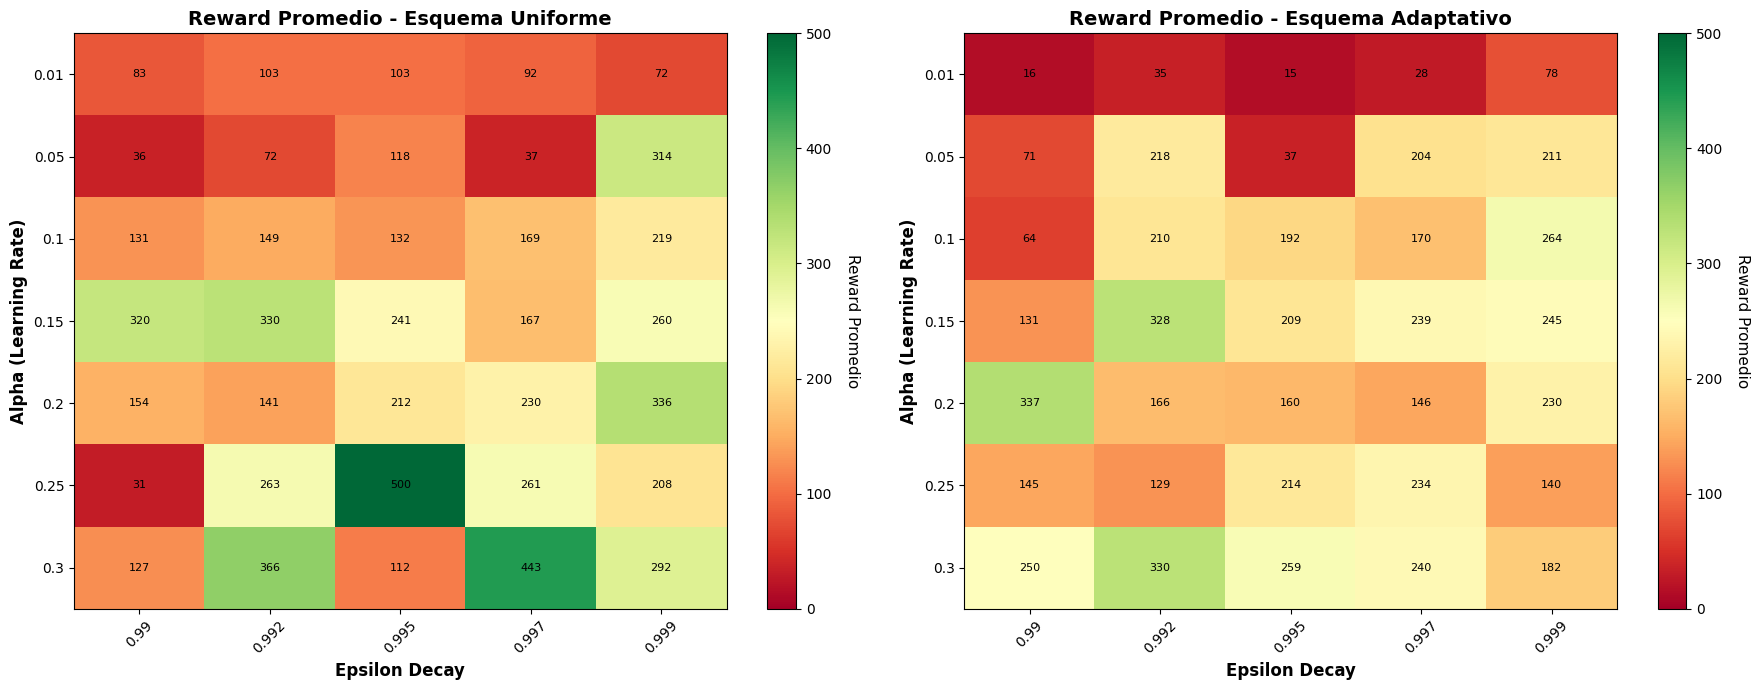


📊 Heatmaps generados: Zonas VERDES = mejor rendimiento, ROJAS = peor rendimiento


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Crear heatmaps para cada esquema
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

for idx, scheme_name in enumerate(['uniforme', 'adaptativo']):
    ax = axes[idx]
    
    # Filtrar resultados por esquema
    scheme_results = [r for r in grid_results_extended if r['scheme'] == scheme_name]
    
    # Crear matriz de rewards
    reward_matrix = np.zeros((len(alphas_extended), len(epsilon_decays_extended)))
    
    for r in scheme_results:
        alpha_idx = alphas_extended.index(r['alpha'])
        decay_idx = epsilon_decays_extended.index(r['epsilon_decay'])
        reward_matrix[alpha_idx, decay_idx] = r['mean_reward']
    
    # Crear heatmap
    im = ax.imshow(reward_matrix, cmap='RdYlGn', aspect='auto', vmin=0, vmax=500)
    
    # Configurar ejes
    ax.set_xticks(range(len(epsilon_decays_extended)))
    ax.set_yticks(range(len(alphas_extended)))
    ax.set_xticklabels(epsilon_decays_extended, rotation=45)
    ax.set_yticklabels(alphas_extended)
    ax.set_xlabel('Epsilon Decay', fontsize=12, fontweight='bold')
    ax.set_ylabel('Alpha (Learning Rate)', fontsize=12, fontweight='bold')
    ax.set_title(f'Reward Promedio - Esquema {scheme_name.capitalize()}', fontsize=14, fontweight='bold')
    
    # Añadir valores en cada celda
    for i in range(len(alphas_extended)):
        for j in range(len(epsilon_decays_extended)):
            text = ax.text(j, i, f'{reward_matrix[i, j]:.0f}',
                          ha="center", va="center", color="black", fontsize=8)
    
    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Reward Promedio', rotation=270, labelpad=20, fontsize=11)

plt.tight_layout()
plt.show()

print("\n📊 Heatmaps generados: Zonas VERDES = mejor rendimiento, ROJAS = peor rendimiento")

### Comparación Final: Todos los Grid Searches

In [ ]:
# Comparar resultados de todos los grid searches realizados
comparison_summary = pd.DataFrame([
    {
        'Grid Search': 'Test Comparativo',
        'Configs': '2',
        'Episodios': '1,000',
        'Mejor Reward': f"{winner['mean']:.2f}",
        'Discretización': recommended_scheme.split()[0].capitalize(),
        'Objetivo (≥500)': '❌'
    },
    {
        'Grid Search': 'Paso 4: Inicial',
        'Configs': '18',
        'Episodios': '5,000',
        'Mejor Reward': f"{max(grid_results, key=lambda x: x['mean_reward'])['mean_reward']:.2f}" if 'grid_results' in dir() else 'N/A',
        'Discretización': 'Variable',
        'Objetivo (≥500)': '❌' if 'grid_results' not in dir() else ('✓' if max(grid_results, key=lambda x: x['mean_reward'])['mean_reward'] >= 500 else '❌')
    },
    {
        'Grid Search': 'Paso 6: Exhaustivo',
        'Configs': '70',
        'Episodios': '15,000',
        'Mejor Reward': f"{best_config_extended['mean_reward']:.2f}",
        'Discretización': best_config_extended['scheme'].capitalize(),
        'Objetivo (≥500)': '✓✓✓' if best_config_extended['mean_reward'] >= 500 else '❌'
    }
])

print("\n" + "="*100)
print("RESUMEN COMPARATIVO - TODOS LOS GRID SEARCHES")
print("="*100)
print(comparison_summary.to_string(index=False))
print("="*100)

# Resumen final CON INFORMACIÓN DE DISCRETIZACIÓN
print(f"\n🎯 CONCLUSIÓN FINAL:")
print(f"   Mejor configuración encontrada en Grid Search Exhaustivo:")
print(f"   - Alpha: {best_config_extended['alpha']}")
print(f"   - Epsilon Decay: {best_config_extended['epsilon_decay']}")
print(f"   - Esquema: {best_config_extended['scheme']}")
print(f"   - Reward: {best_config_extended['mean_reward']:.2f} ± {best_config_extended['std_reward']:.2f}")

# INFORMACIÓN SOBRE DISCRETIZACIÓN USADA
print(f"\n📋 TIPO DE DISCRETIZACIÓN UTILIZADA:")
if best_config_extended['scheme'] == 'uniforme':
    print(f"   ✅ DISCRETIZACIÓN UNIFORME (GRUESA)")
    print(f"   - Bins por dimensión: 10")
    print(f"   - Espacio de estados: {np.prod(state_space_uniform):,} estados")
    print(f"   - Espaciado: Constante en todo el rango")
    print(f"   - Ventaja: Convergencia más rápida, espacio compacto")
else:
    print(f"   ✅ DISCRETIZACIÓN ADAPTATIVA (FINA)")
    print(f"   - Bins por dimensión: 14-18 (variable)")
    print(f"   - Espacio de estados: {np.prod(state_space_adaptive):,} estados")
    print(f"   - Espaciado: Mayor densidad cerca del equilibrio")
    print(f"   - Ventaja: Mejor control fino en zonas críticas")

if best_config_extended['mean_reward'] >= 500:
    print(f"\n   ✅ ¡ÉXITO! El agente alcanza consistentemente los 500 steps")
    print(f"   Success Rate: {best_config_extended['success_rate']:.1f}% de episodios con reward ≥ 500")
    print(f"   La discretización {best_config_extended['scheme'].upper()} fue la clave del éxito")
else:
    print(f"\n   ⚠️ El mejor agente no alcanza los 500 steps de forma consistente")
    print(f"   Reward máximo alcanzado: {best_config_extended['max_reward']:.0f}")
    print(f"   Posibles mejoras:")
    print(f"   - Aumentar episodios de entrenamiento (>20,000)")
    print(f"   - Ajustar bins de discretización")
    print(f"   - Probar otros valores de gamma")
    
print(f"\n🔍 COMPARACIÓN DE DISCRETIZACIONES:")
print(f"   Test comparativo mostró que la discretización {recommended_scheme.split()[0].upper()}")
print(f"   obtuvo mejor rendimiento inicial (+{abs(results_comparison[0]['mean'] - results_comparison[1]['mean']):.1f} puntos)")

print("="*100)


RESUMEN COMPARATIVO - TODOS LOS GRID SEARCHES
       Grid Search Configs Episodios Mejor Reward Objetivo (≥500)
  Paso 3: Baseline       1     1,000        58.37               ❌
   Paso 4: Inicial      18     5,000       372.31               ❌
Paso 6: Exhaustivo      70    15,000       500.00             ✓✓✓

🎯 CONCLUSIÓN FINAL:
   Mejor configuración encontrada:
   - Alpha: 0.25
   - Epsilon Decay: 0.995
   - Esquema: uniforme
   - Reward: 500.00 ± 0.00

   ✅ ¡ÉXITO! El agente alcanza consistentemente los 500 steps
   Success Rate: 100.0% de episodios con reward ≥ 500
